Please refer to my [Medium article](https://medium.com/@fernandopalominocobo/mastering-u-net-a-step-by-step-guide-to-segmentation-from-scratch-with-pytorch-6a17c5916114) for code explanations!!

# Load the required libraries

In [2]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# U-Net architecture

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


In [4]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [5]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)

        self.bottle_neck = DoubleConv(256, 512)

        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)

        b = self.bottle_neck(p3)

        up_2 = self.up_convolution_2(b, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


In [7]:
input_image = torch.rand((1,3,128,128))
model = UNet(3,10)
output = model(input_image)
print(output.size())
# You should get torch.Size([1, 10, 512, 512]) as a result

torch.Size([1, 10, 128, 128])


# Load the Carvana Dataset

In [8]:
class CarvanaDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train/")])[:self.limit]
        self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks/")])[:self.limit]

        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()])
        
        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask), self.images[index]

    def __len__(self):
        
        return min(len(self.images), self.limit)

In [15]:

print(os.listdir("caravana/train/"))

DATASET_DIR = 'caravana/'
WORKING_DIR = '.'

['bd8d5780ed04_07.jpg', '6752de44b721_01.jpg', '1390696b70b6_02.jpg', 'ce74dfdf123b_04.jpg', 'ce74dfdf123b_10.jpg', '1390696b70b6_16.jpg', '6752de44b721_15.jpg', '292f59c6a347_03.jpg', 'bd8d5780ed04_13.jpg', '8d5423cb763c_13.jpg', '898339fab87a_05.jpg', '7251c8797749_10.jpg', '7ac210ba75a1_01.jpg', '917f262f1608_10.jpg', '11fcda0a9e1c_08.jpg', '858841907a4a_16.jpg', '2f39abb12388_08.jpg', 'acb0fd30b83d_13.jpg', 'e5fc2c1c4a8b_12.jpg', 'b24fd9084449_03.jpg', 'acb0fd30b83d_07.jpg', 'e5fc2c1c4a8b_06.jpg', '917f262f1608_04.jpg', '858841907a4a_02.jpg', '7ac210ba75a1_15.jpg', '8d5423cb763c_07.jpg', '898339fab87a_11.jpg', '7251c8797749_04.jpg', '0d1a9caf4350_12.jpg', '42d81612e2ce_07.jpg', '9dfaeb835626_11.jpg', 'c3dafdb02e7f_02.jpg', '3a7a8f03e713_02.jpg', '6f6dced498c4_05.jpg', '1e6f48393e17_03.jpg', '65051cfe0789_09.jpg', 'eefc0d8c94f0_08.jpg', 'c3dafdb02e7f_16.jpg', '3a7a8f03e713_16.jpg', '6f6dced498c4_11.jpg', '42d81612e2ce_13.jpg', '9dfaeb835626_05.jpg', '2cb91c2543fa_09.jpg', '0d1a9caf4

In [16]:
train_dataset = CarvanaDataset(DATASET_DIR, limit=2000)

generator = torch.Generator().manual_seed(25)

In [17]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

In [18]:
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

In [26]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [27]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 5
out_checkpoint = 'my_checkpoint_small.pth'

In [28]:
train_dataloader = DataLoader(dataset=train_dataset,
                              pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

# Running the experiment

In [29]:

def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [30]:
torch.mps.empty_cache()

In [31]:
EPOCHS = 10

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask)
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

# Guardar el modelo
torch.save(model.state_dict(), out_checkpoint)


 10%|█         | 1/10 [00:50<07:36, 50.69s/it]

------------------------------
Training Loss EPOCH 1: 0.1894
Training DICE EPOCH 1: 0.7710


Validation Loss EPOCH 1: 0.1031
Validation DICE EPOCH 1: 0.9070
------------------------------


 20%|██        | 2/10 [01:34<06:11, 46.50s/it]

------------------------------
Training Loss EPOCH 2: 0.0592
Training DICE EPOCH 2: 0.9414


Validation Loss EPOCH 2: 0.0458
Validation DICE EPOCH 2: 0.9554
------------------------------


 30%|███       | 3/10 [02:17<05:15, 45.08s/it]

------------------------------
Training Loss EPOCH 3: 0.0398
Training DICE EPOCH 3: 0.9613


Validation Loss EPOCH 3: 0.0299
Validation DICE EPOCH 3: 0.9713
------------------------------


 40%|████      | 4/10 [03:00<04:26, 44.36s/it]

------------------------------
Training Loss EPOCH 4: 0.0272
Training DICE EPOCH 4: 0.9733


Validation Loss EPOCH 4: 0.0258
Validation DICE EPOCH 4: 0.9755
------------------------------


 50%|█████     | 5/10 [03:44<03:39, 43.97s/it]

------------------------------
Training Loss EPOCH 5: 0.0236
Training DICE EPOCH 5: 0.9768


Validation Loss EPOCH 5: 0.0239
Validation DICE EPOCH 5: 0.9776
------------------------------


 60%|██████    | 6/10 [04:27<02:54, 43.74s/it]

------------------------------
Training Loss EPOCH 6: 0.0219
Training DICE EPOCH 6: 0.9787


Validation Loss EPOCH 6: 0.0221
Validation DICE EPOCH 6: 0.9794
------------------------------


 70%|███████   | 7/10 [05:10<02:10, 43.58s/it]

------------------------------
Training Loss EPOCH 7: 0.0199
Training DICE EPOCH 7: 0.9806


Validation Loss EPOCH 7: 0.0207
Validation DICE EPOCH 7: 0.9805
------------------------------


 80%|████████  | 8/10 [05:53<01:26, 43.49s/it]

------------------------------
Training Loss EPOCH 8: 0.0187
Training DICE EPOCH 8: 0.9816


Validation Loss EPOCH 8: 0.0199
Validation DICE EPOCH 8: 0.9813
------------------------------


 90%|█████████ | 9/10 [06:37<00:43, 43.46s/it]

------------------------------
Training Loss EPOCH 9: 0.0294
Training DICE EPOCH 9: 0.9728


Validation Loss EPOCH 9: 0.0232
Validation DICE EPOCH 9: 0.9781
------------------------------


100%|██████████| 10/10 [07:20<00:00, 44.09s/it]


------------------------------
Training Loss EPOCH 10: 0.0193
Training DICE EPOCH 10: 0.9812


Validation Loss EPOCH 10: 0.0201
Validation DICE EPOCH 10: 0.9811
------------------------------


# Results

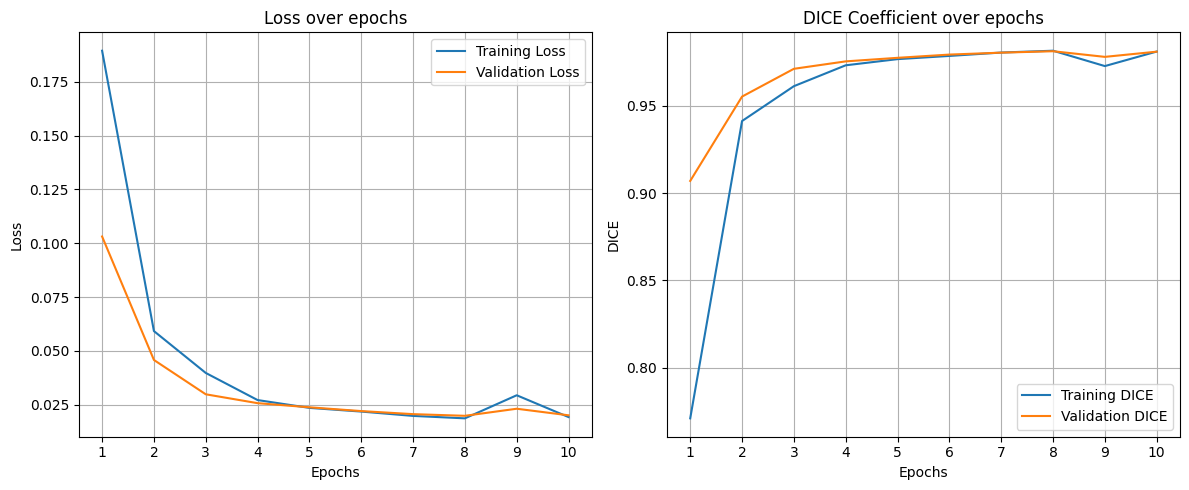

In [32]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


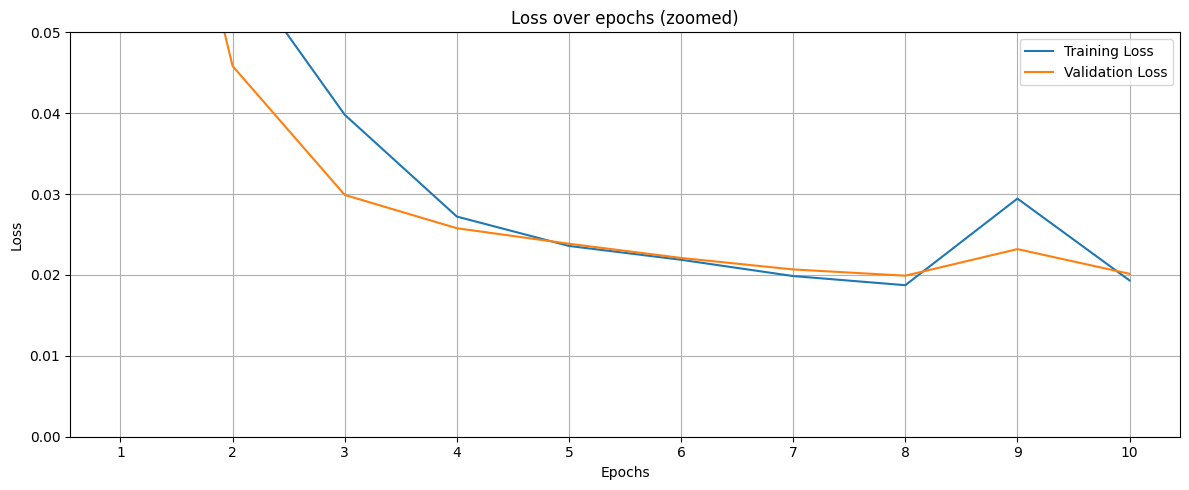

In [33]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.ylim(0, 0.05)
plt.title('Loss over epochs (zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()
plt.show()



In [34]:
model_pth = out_checkpoint
trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

/var/folders/jz/2_hd4nqn28g06sslk4s2d6380000gn/T/ipykernel_58042/2086810339.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(mode

<All keys matched successfully>

In [35]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)


100%|██████████| 40/40 [00:01<00:00, 23.68it/s]


In [36]:
test_loss

0.01898688324727118

In [37]:
test_dc

0.9810673043131828

In [38]:
def random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device, flip=False):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    if flip:
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(p=1.0)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((128, 128))
        ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)
        
        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)
        
        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)),5)}")
        
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1
        
        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.show()


In [39]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 



/var/folders/jz/2_hd4nqn28g06sslk4s2d6380000gn/T/ipykernel_58042/3286164370.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, m

Image: 11f3dc041cfb_03.jpg, DICE coefficient: 0.97305


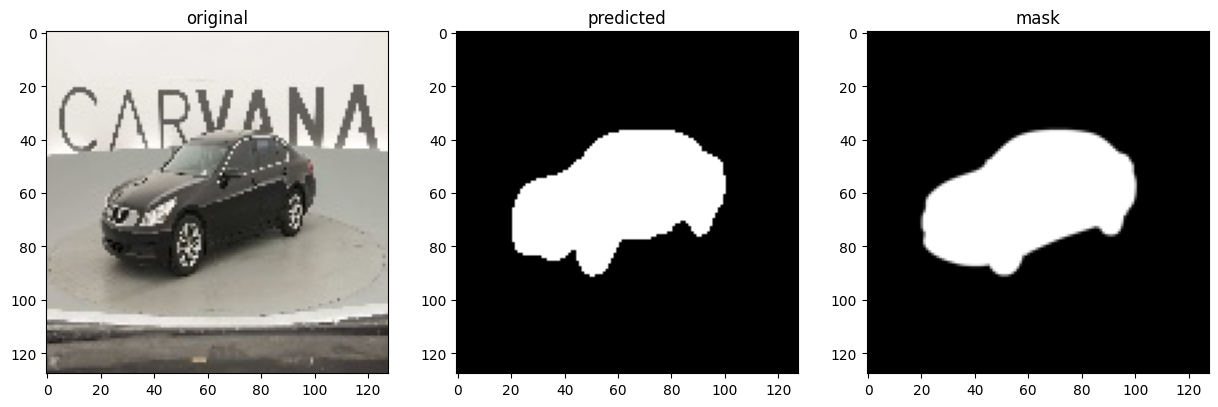

Image: 169f5f6d8c9d_04.jpg, DICE coefficient: 0.9836


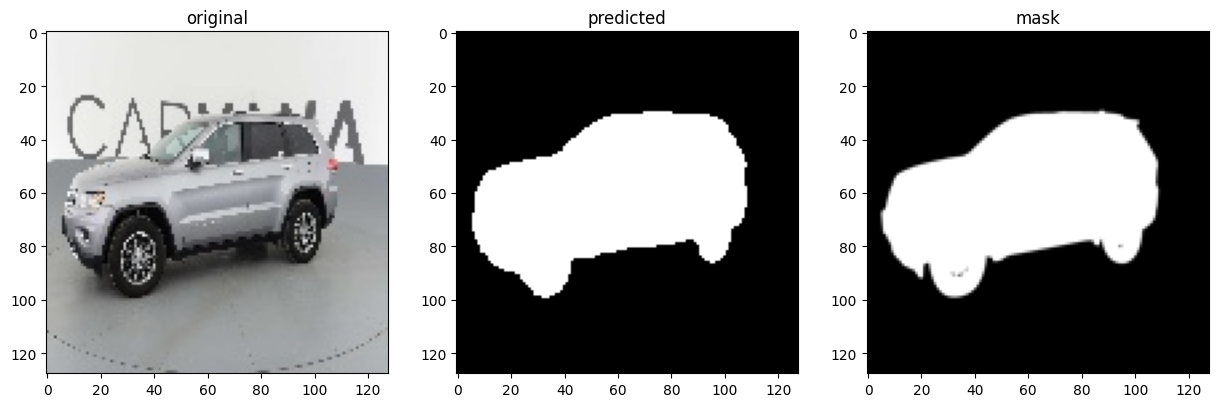

Image: 3810c5e1cdeb_10.jpg, DICE coefficient: 0.98163


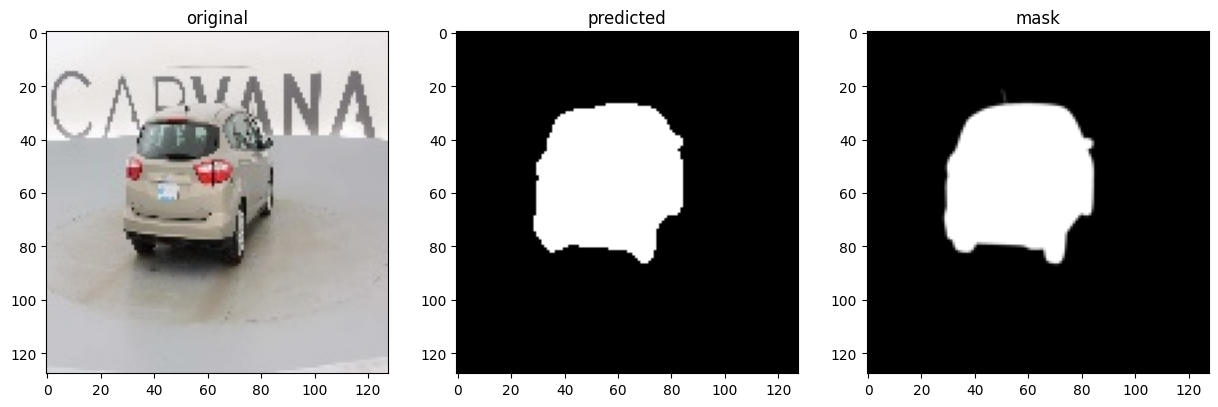

Image: 42a3297ccd4b_12.jpg, DICE coefficient: 0.98275


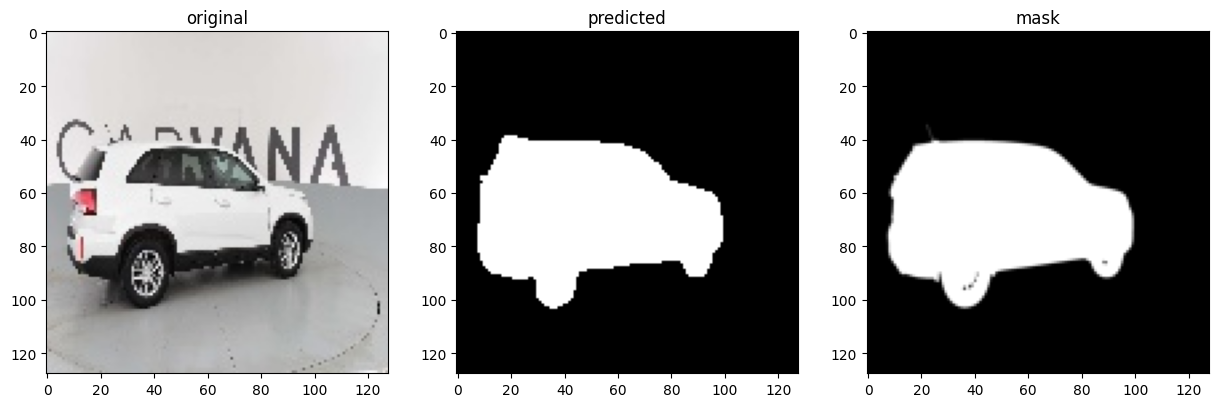

Image: 28109f18d9d4_09.jpg, DICE coefficient: 0.96798


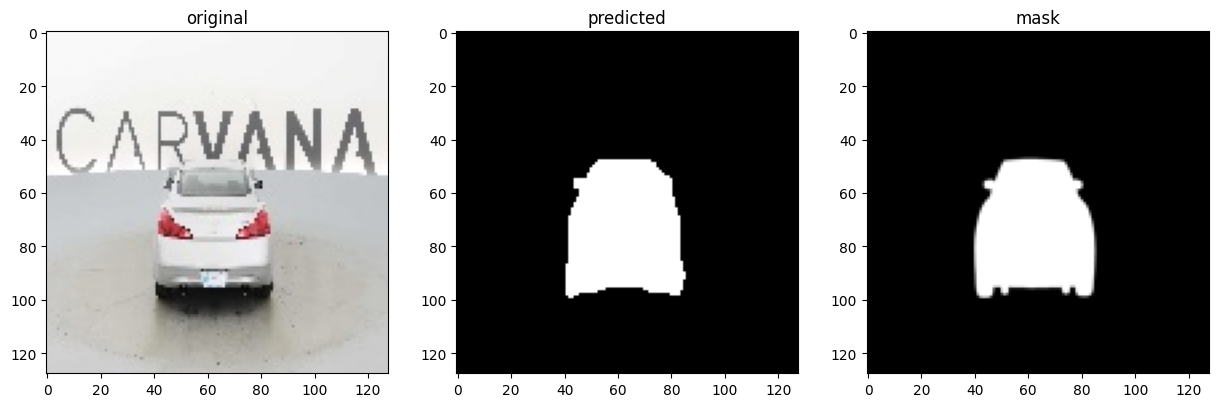

Image: 364923a5002f_04.jpg, DICE coefficient: 0.97955


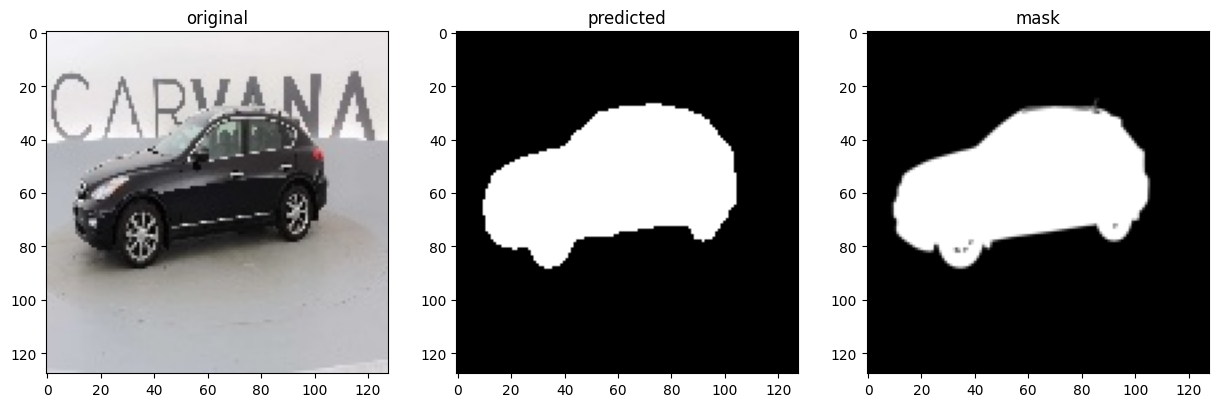

Image: 3a7a8f03e713_02.jpg, DICE coefficient: 0.98215


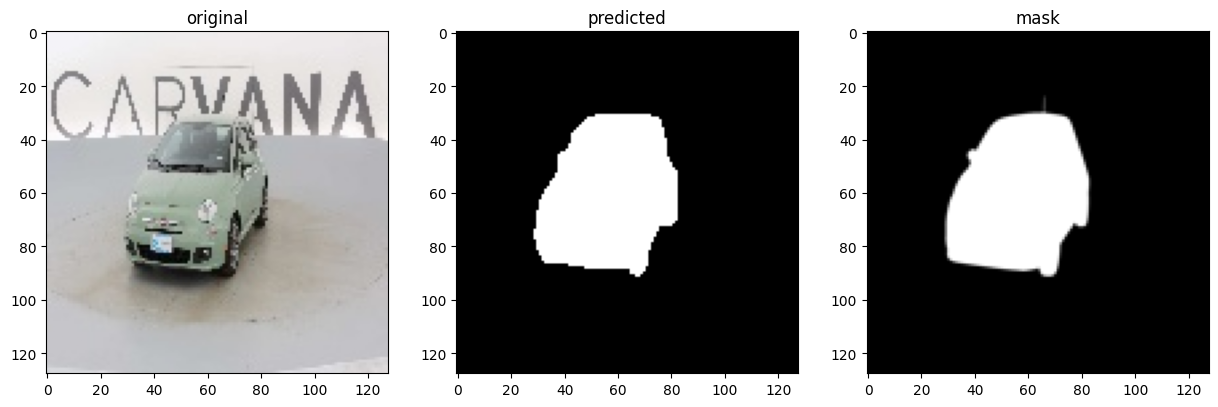

Image: 04bd942b463b_16.jpg, DICE coefficient: 0.98225


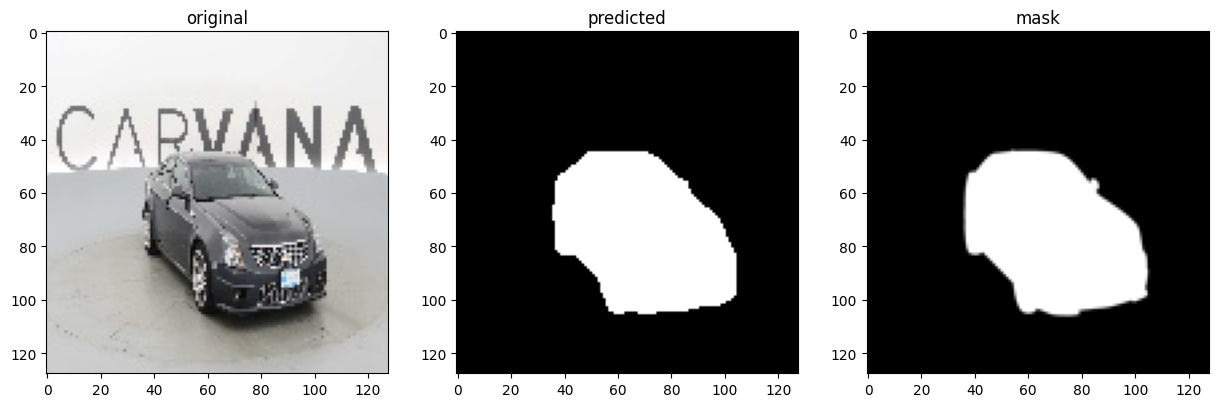

Image: 42a3297ccd4b_12.jpg, DICE coefficient: 0.98275


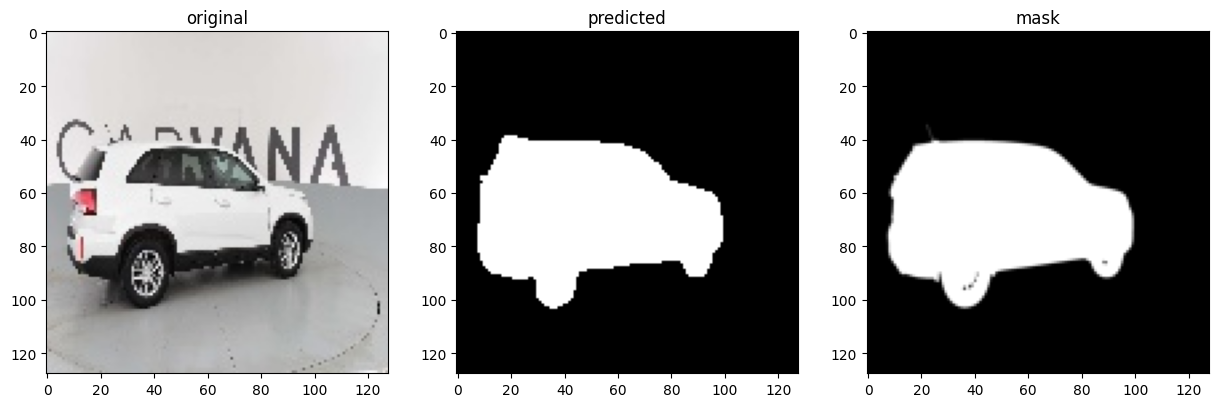

Image: 0ee135a3cccc_09.jpg, DICE coefficient: 0.98072


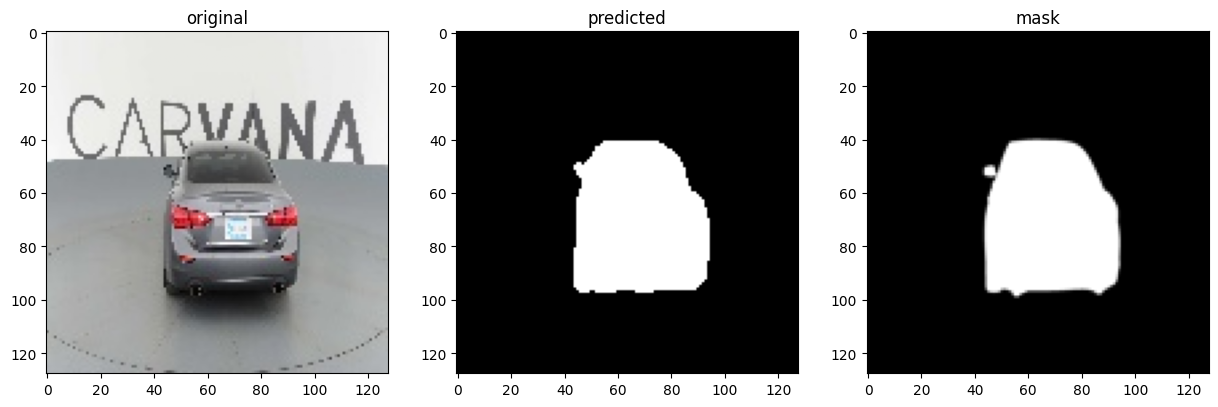

In [40]:
model_path = out_checkpoint

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu")

# Optional: checking the masks in the training

/var/folders/jz/2_hd4nqn28g06sslk4s2d6380000gn/T/ipykernel_58042/3286164370.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, m

Image: 0ee135a3cccc_12.jpg, DICE coefficient: 0.98681


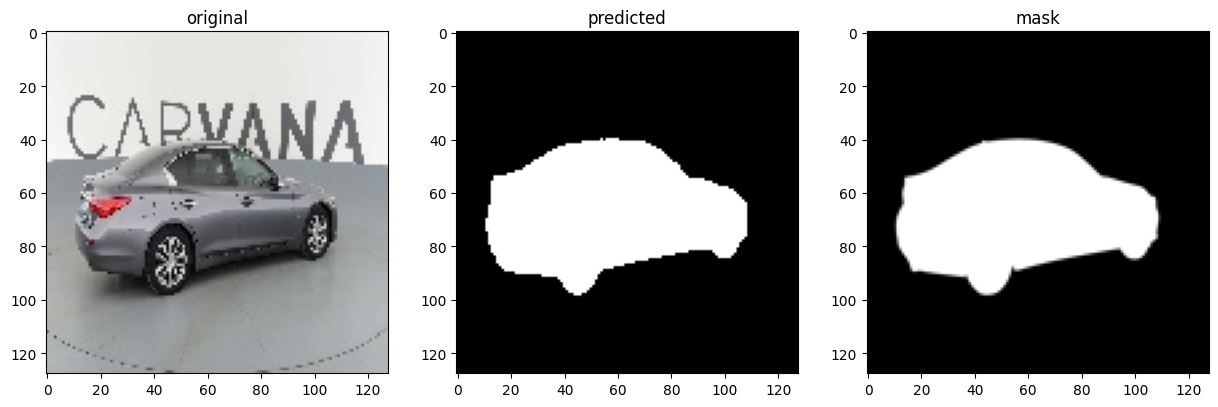

Image: 42b3feca1993_09.jpg, DICE coefficient: 0.97936


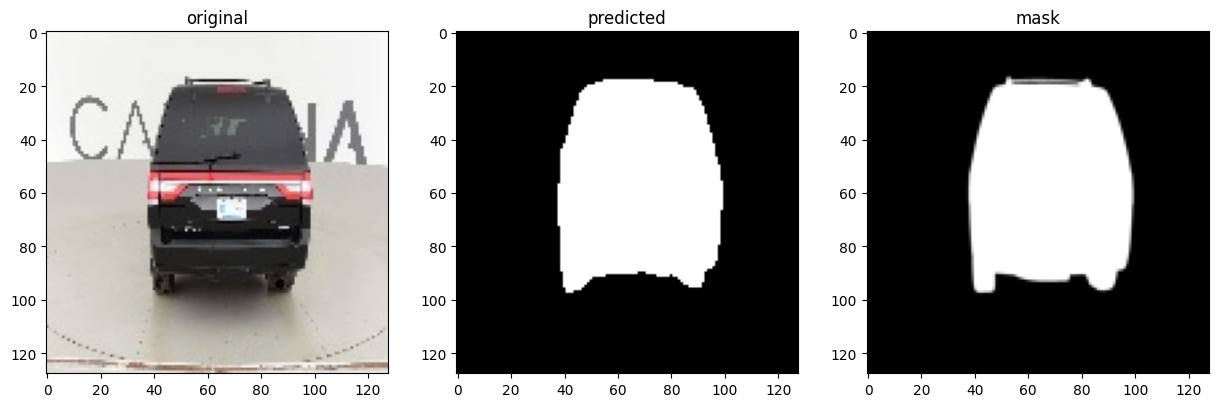

Image: 42b3feca1993_06.jpg, DICE coefficient: 0.9799


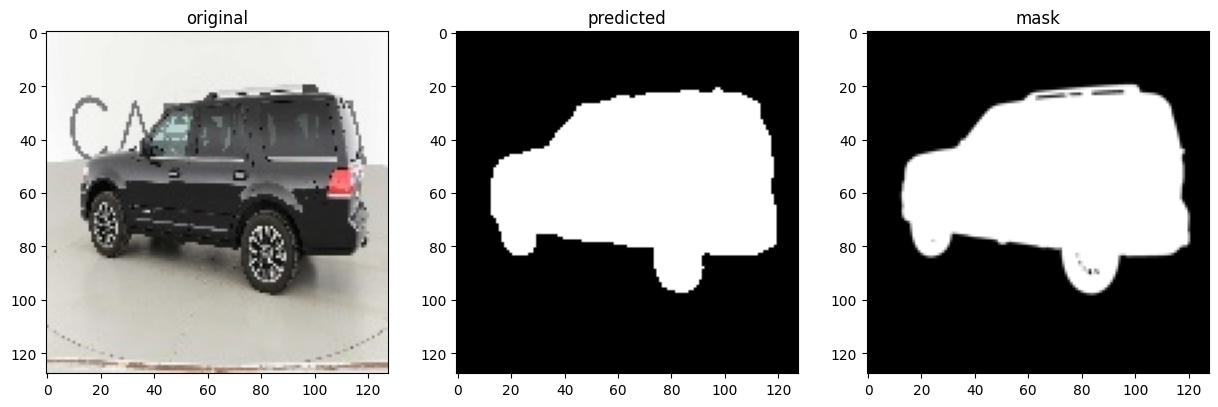

Image: 0de66245f268_10.jpg, DICE coefficient: 0.98649


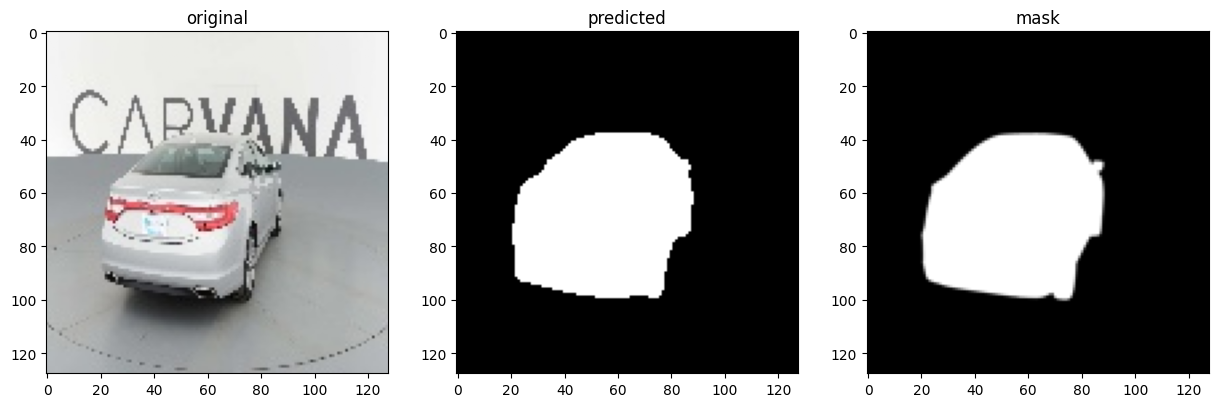

Image: 0789bed99cb8_10.jpg, DICE coefficient: 0.98423


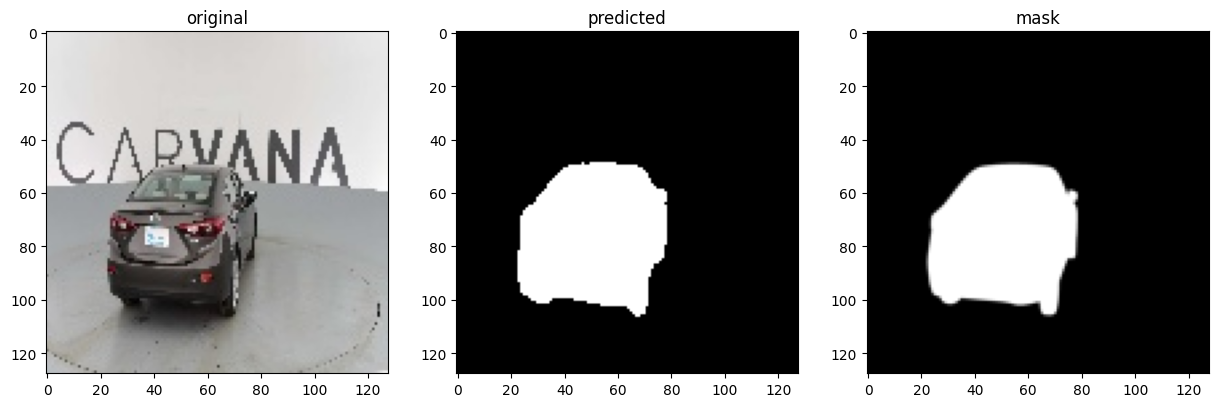

Image: 42415ff65013_10.jpg, DICE coefficient: 0.98429


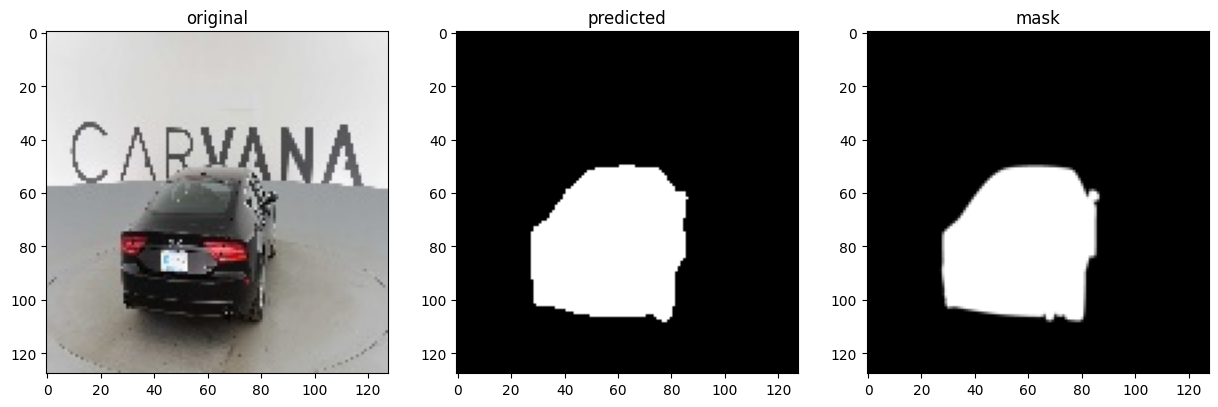

Image: 2990f858e939_16.jpg, DICE coefficient: 0.9844


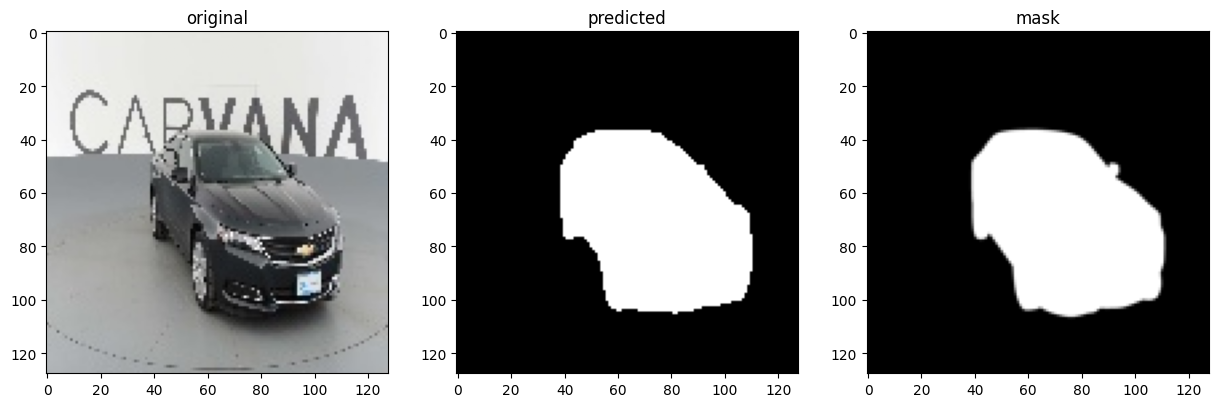

Image: 5a194c1384f3_04.jpg, DICE coefficient: 0.9871


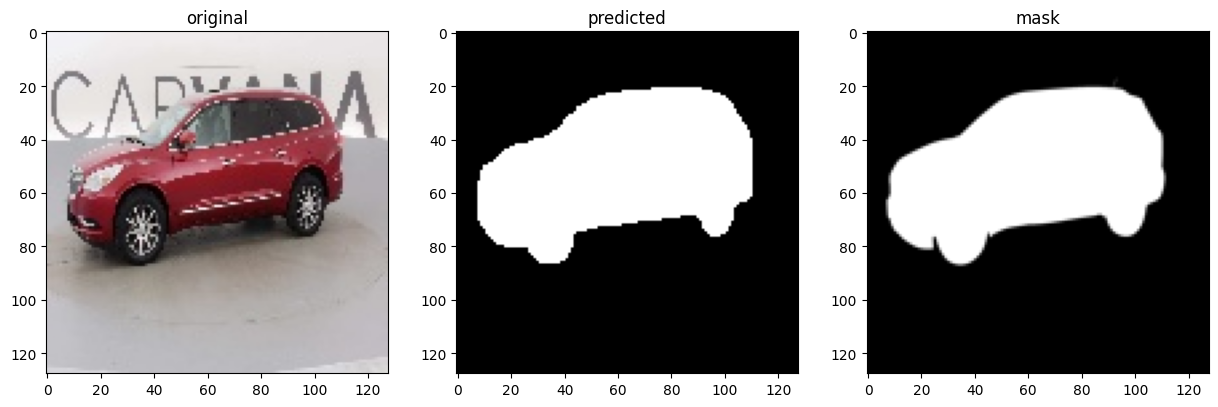

Image: 26ccab021981_15.jpg, DICE coefficient: 0.98048


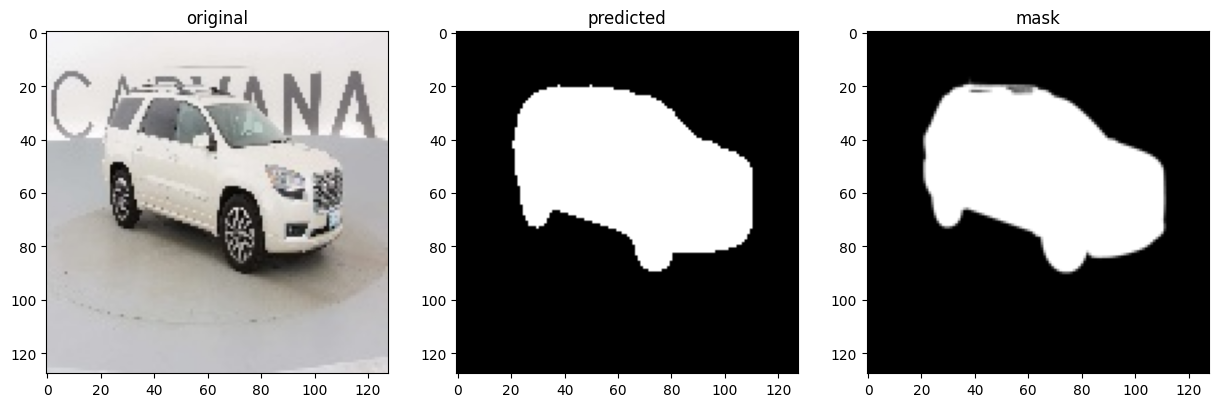

Image: 48b3f0c936b5_13.jpg, DICE coefficient: 0.97987


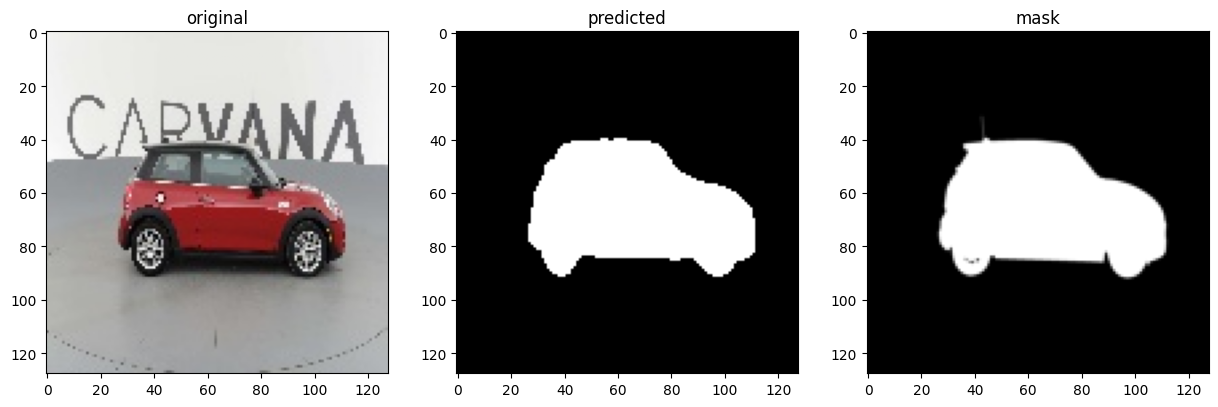

In [41]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu")

/var/folders/jz/2_hd4nqn28g06sslk4s2d6380000gn/T/ipykernel_58042/3286164370.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, m

Image: 11acc40dc0ea_06.jpg, DICE coefficient: 0.98078


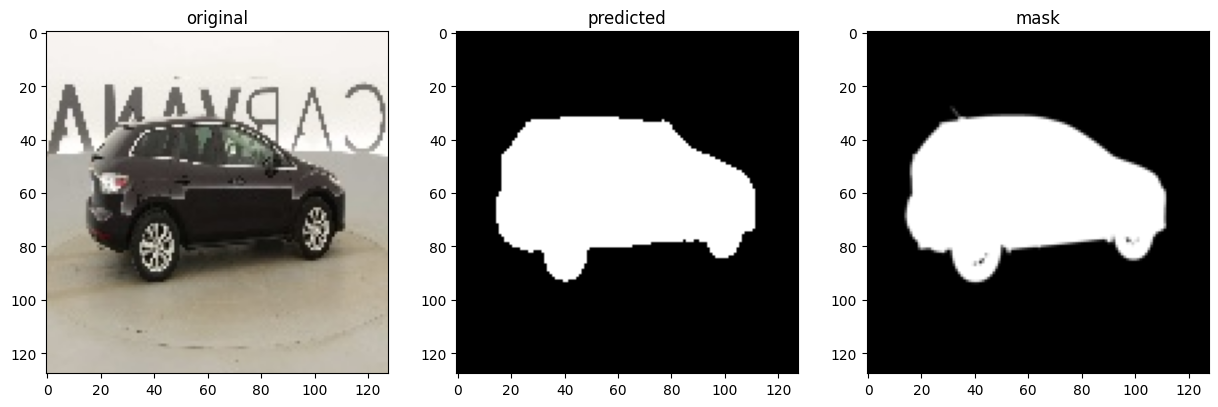

Image: 04bd942b463b_06.jpg, DICE coefficient: 0.98107


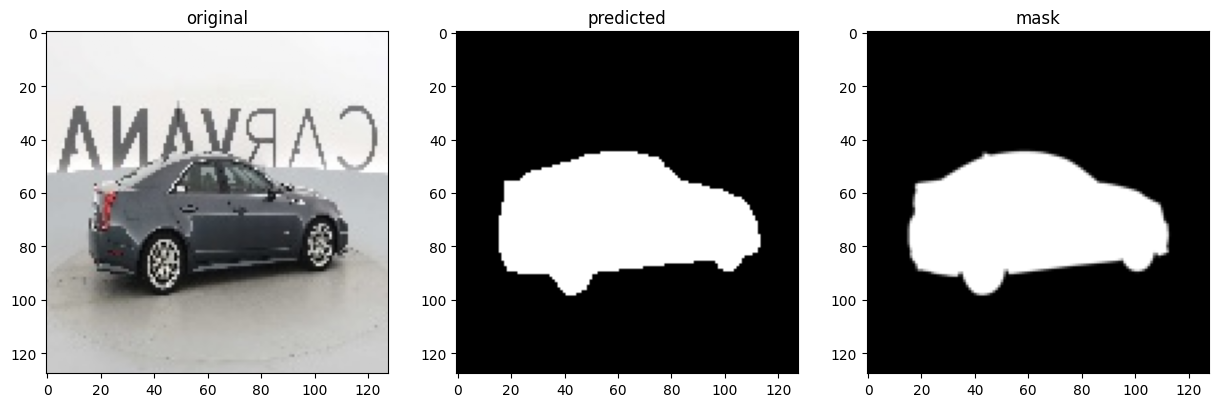

Image: 11fcda0a9e1c_05.jpg, DICE coefficient: 0.97747


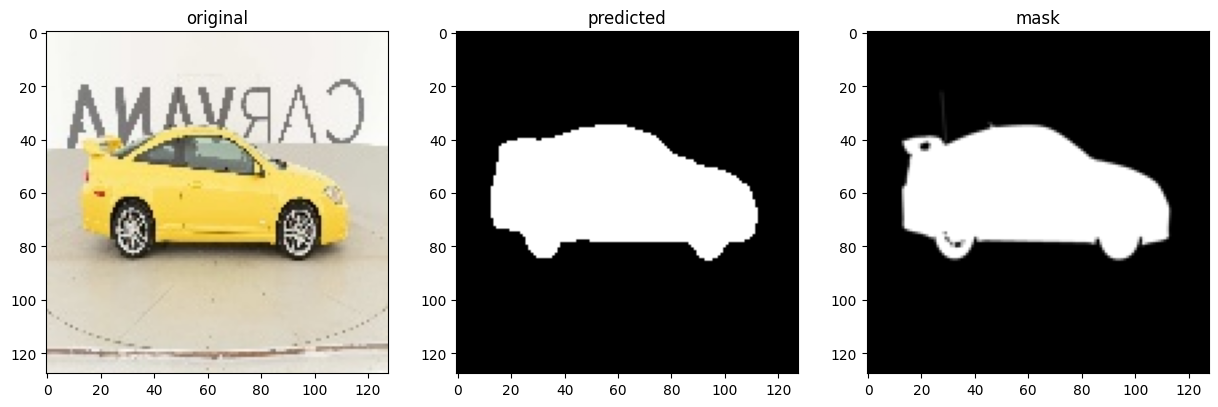

Image: 1b25ea8ba94d_06.jpg, DICE coefficient: 0.98384


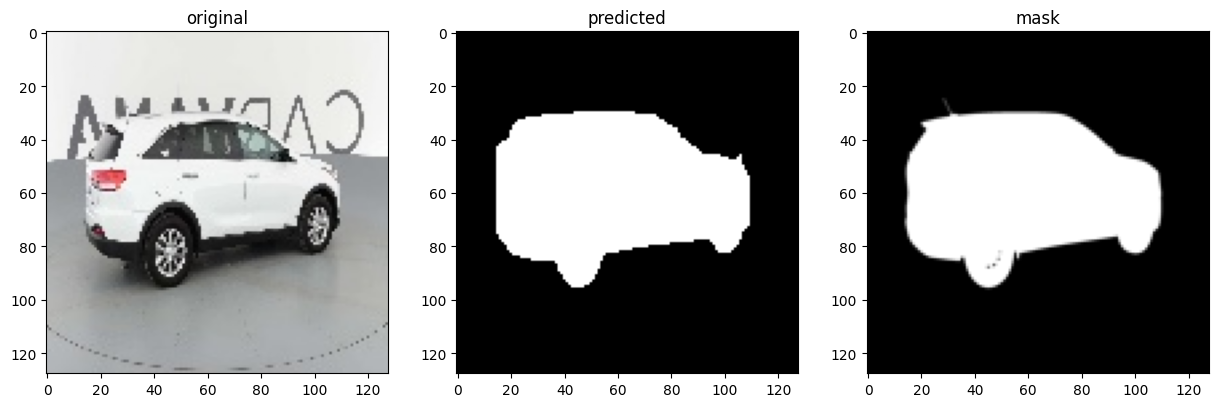

Image: 2990f858e939_06.jpg, DICE coefficient: 0.98424


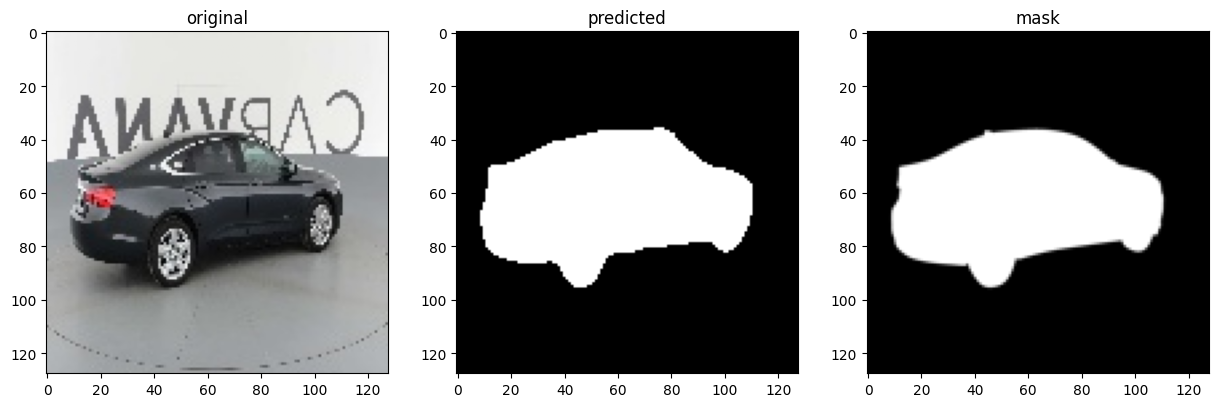

Image: 5d95d80e10a9_04.jpg, DICE coefficient: 0.9769


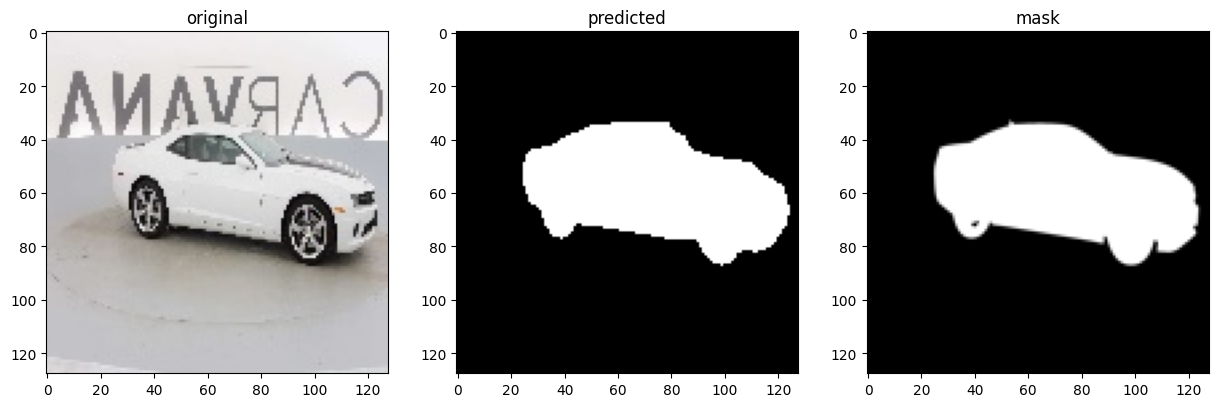

Image: 4dc8a7fe7c02_08.jpg, DICE coefficient: 0.98513


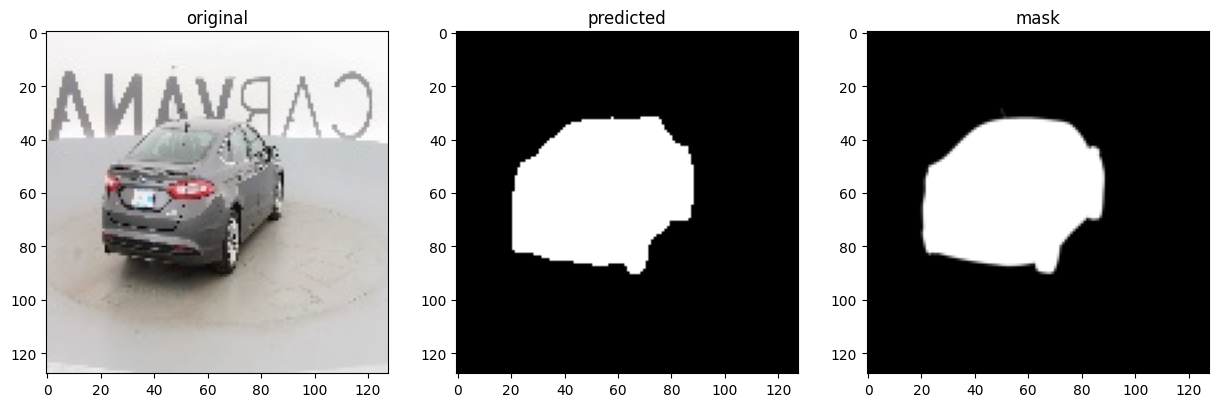

Image: 351c583eabd6_11.jpg, DICE coefficient: 0.98331


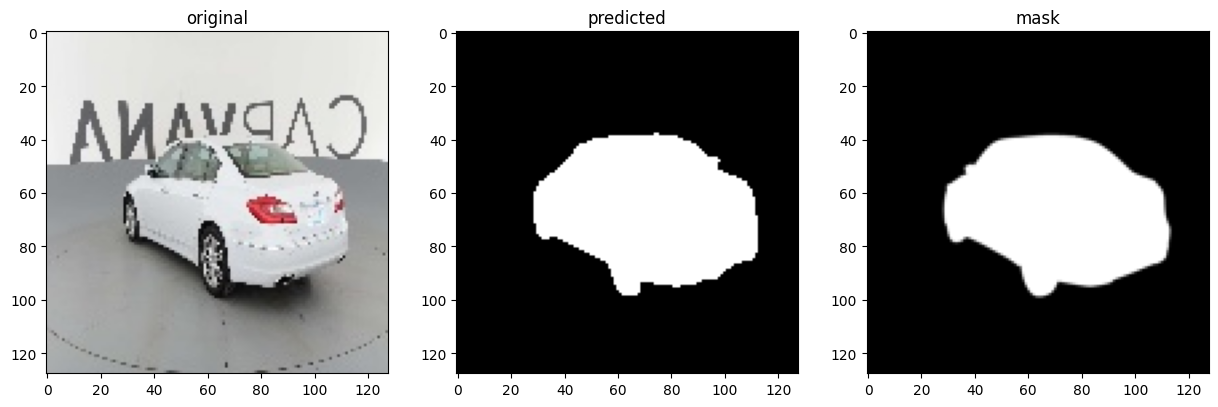

Image: 371f057d1242_12.jpg, DICE coefficient: 0.97755


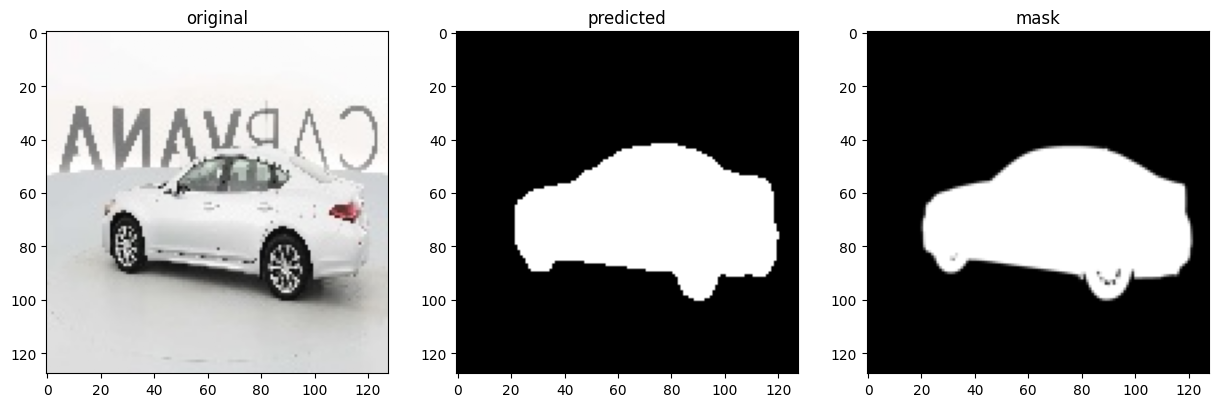

Image: 47ea8f25c948_13.jpg, DICE coefficient: 0.97744


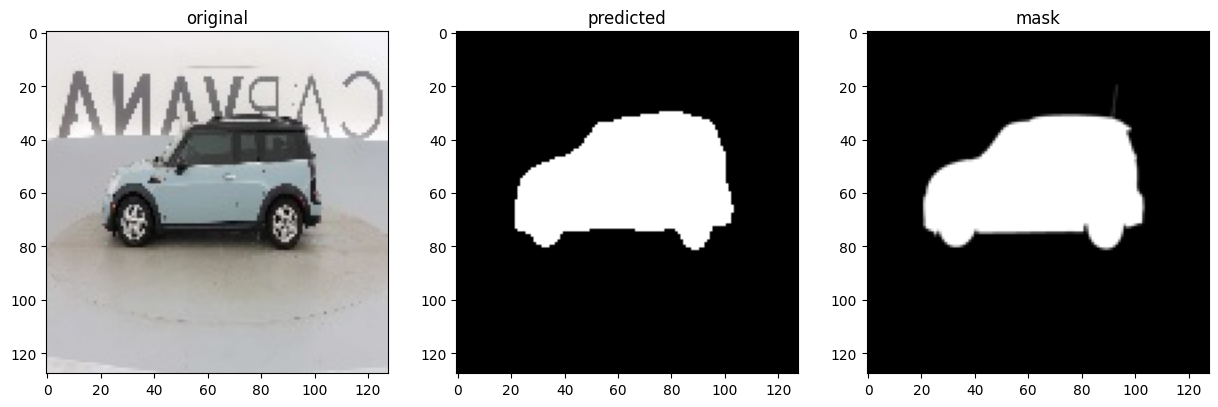

In [42]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2]) 

random_images_inference(image_tensors, mask_tensors, image_paths, model_path, device="cpu", flip=True)